Latent Dirichlet Allocation
===

Preparación
----

In [59]:
import pandas as pd

scopus = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/scopus-abstracts.csv")
scopus['Abstract'].head()

0    Mobility is one of the fundamental requirement...
1    The recent rise of the political extremism in ...
2    The power of the press to shape the informatio...
3    Identifying influential nodes in a network is ...
4    To complement traditional dietary surveys, whi...
Name: Abstract, dtype: object

Descripción del problema
---

Uno de los principales problemas abordados en minería de texto consiste en la extracción de los temas o tópicos a los que pertenece documento. Por ejemplo, una noticia podría pertener simultáneamente a los temas de religión y economía (el escándalo por el manejo de fondos del Vaticano). Cuando se tiene un conjunto de documentos, se desea extraer los tópicos subyacentes sobre los que tratan los documentos.

Scikit-learn contiene una implementación de la metodología Latent Dirichlet Allocation, la cual permite extraer los tópicos de un conjunto de documentos. Véase https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

Utilice esta metodología para extraer los tópicos subyacentes en los abstracts de los artículos. Tenga en cuenta que:

1. Debe establecer como obtener el número apropiado de tópicos a obtener.

2. Debe eliminar las stop-words.

3. En T-Lab sugieren reducir las palabras a sustantivos, adjetivos, verbos y adverbios únicamente. Cómo podría realizar esto en su código=?

4. Cómo podría verificar si la cantidad de temas es apropiada desde el punto de vista de su contenido (las palabras que contiene y los temas que trata)?


In [60]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import warnings
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from gensim.models import CoherenceModel

# init
warnings.filterwarnings("ignore")
%matplotlib inline

In [61]:
scopus.Abstract
scopus.head(5)


,DOI,Link,Abstract
0,10.1140/epjds/s13688-019-0196-6,https://www.scopus.com/inward/record.uri?eid=2...,Mobility is one of the fundamental requirement...
1,10.1140/epjds/s13688-019-0193-9,https://www.scopus.com/inward/record.uri?eid=2...,The recent rise of the political extremism in ...
2,10.1140/epjds/s13688-019-0194-8,https://www.scopus.com/inward/record.uri?eid=2...,The power of the press to shape the informatio...
3,10.1140/epjds/s13688-019-0195-7,https://www.scopus.com/inward/record.uri?eid=2...,Identifying influential nodes in a network is ...
4,10.1140/epjds/s13688-019-0191-y,https://www.scopus.com/inward/record.uri?eid=2...,"To complement traditional dietary surveys, whi..."


In [62]:
# Limpiar los datos

datos = scopus.Abstract.values.tolist()

# Remove Emails- Reemplazarlos por vacío
datos = [re.sub(r'\S*@\S*\s?', '', sent) for sent in datos]
# Remove new line characters
datos = [re.sub(r'\s+', ' ', sent) for sent in datos]
# Remove distracting single quotes
datos = [re.sub(r"\'", "", sent) for sent in datos]
pprint(datos[:1])
pprint(scopus.shape)


['Mobility is one of the fundamental requirements of human life with '
 'significant societal impacts including productivity, economy, social '
 'wellbeing, adaptation to a changing climate, and so on. Although human '
 'movements follow specific patterns during normal periods, there are limited '
 'studies on how such patterns change due to extreme events. To quantify the '
 'impacts of an extreme event to human movements, we introduce the concept of '
 'mobility resilience which is defined as the ability of a mobility system to '
 'manage shocks and return to a steady state in response to an extreme event. '
 'We present a method to detect extreme events from geo-located movement data '
 'and to measure mobility resilience and transient loss of resilience due to '
 'those events. Applying this method, we measure resilience metrics from '
 'geo-located social media data for multiple types of disasters occurred all '
 'over the world. Quantifying mobility resilience may help us to asse

In [63]:
#Convertir el documento en tokens - listas de palabras-
def sent_to_words(sentences):
  for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True eliminar puntuación
data_words = list(sent_to_words(datos))  #datos tokenizados
print(data_words[:1])

[['mobility', 'is', 'one', 'of', 'the', 'fundamental', 'requirements', 'of', 'human', 'life', 'with', 'significant', 'societal', 'impacts', 'including', 'productivity', 'economy', 'social', 'wellbeing', 'adaptation', 'to', 'changing', 'climate', 'and', 'so', 'on', 'although', 'human', 'movements', 'follow', 'specific', 'patterns', 'during', 'normal', 'periods', 'there', 'are', 'limited', 'studies', 'on', 'how', 'such', 'patterns', 'change', 'due', 'to', 'extreme', 'events', 'to', 'quantify', 'the', 'impacts', 'of', 'an', 'extreme', 'event', 'to', 'human', 'movements', 'we', 'introduce', 'the', 'concept', 'of', 'mobility', 'resilience', 'which', 'is', 'defined', 'as', 'the', 'ability', 'of', 'mobility', 'system', 'to', 'manage', 'shocks', 'and', 'return', 'to', 'steady', 'state', 'in', 'response', 'to', 'an', 'extreme', 'event', 'we', 'present', 'method', 'to', 'detect', 'extreme', 'events', 'from', 'geo', 'located', 'movement', 'data', 'and', 'to', 'measure', 'mobility', 'resilience', 

In [64]:
# LEMATIZACIÓN- Reducción del documento a sustantivos, adjetivos, verbos y adverbios.

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

  # Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en-English
nlp = spacy.load('en', disable=['parser', 'ner'])  

# Parser-analizador de dependencias que aprende conjuntamente la segmentación de oraciones.
# Ner- Reconocedor de entidades que identifica tramos de tokens
# Tagger- componente entrenable para predecir etiquetas

data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) #select noun and verb
print(data_lemmatized[:2])
print (type(data_lemmatized))
#x = data_lemmatized.split(" ")
#print(x)
#print(data_lemmatized.size)
#df_keyword['Author Keywords'][linea].split(';')

['mobility fundamental requirement human life significant societal impact include productivity economy social wellbeing adaptation change climate so on human movement follow specific pattern normal period limited study how such pattern change extreme event quantify impact extreme event human movement introduce concept mobility resilience define ability mobility system manage shock return steady state response extreme event present method detect extreme event locate movement datum measure mobility resilience transient loss resilience event apply method measure resilience metric locate social medium datum multiple type disaster occur all world quantifying mobility resilience may help assess high order economic impact extreme event guide policy develop resilient infrastructure as well nation overall disaster resilience strategie author', 'recent rise political extremism western country spur renew interest psychological moral appeal political extremism empirical support psychological expla

In [65]:
from gensim.corpora.dictionary import Dictionary
y=[i.split(' ') for i in data_lemmatized ]
print(type(y))
#dic=[]
dictionary = Dictionary(y)
dictionary
#data_lemmatized

<class 'list'>


In [66]:
# Matriz documento término

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,# minimum reqd occurences of a word 
                             stop_words='english', # remove stop words
                             lowercase=True, # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,    # max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

terms = vectorizer.get_feature_names()
len(terms)
print(data_lemmatized)

['mobility fundamental requirement human life significant societal impact include productivity economy social wellbeing adaptation change climate so on human movement follow specific pattern normal period limited study how such pattern change extreme event quantify impact extreme event human movement introduce concept mobility resilience define ability mobility system manage shock return steady state response extreme event present method detect extreme event locate movement datum measure mobility resilience transient loss resilience event apply method measure resilience metric locate social medium datum multiple type disaster occur all world quantifying mobility resilience may help assess high order economic impact extreme event guide policy develop resilient infrastructure as well nation overall disaster resilience strategie author', 'recent rise political extremism western country spur renew interest psychological moral appeal political extremism empirical support psychological expla

In [67]:
from sklearn.model_selection import train_test_split

prueba, entrenamiento =train_test_split(y, test_size=0.3)
len(entrenamiento), len(prueba),len(y)


(571, 1331, 1902)

In [68]:
import gensim.corpora as corpora

#Diccionario
id2word = corpora.Dictionary(y)

 #Corpus
texts = y

 #Frecuencia de terminos
corpus = [id2word.doc2bow(text) for text in texts]

#print(corpus[:1])
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 6), (18, 5), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 3), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 5), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 6), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1)], [(6, 1), (10, 1), (23, 1), (36, 1), (62, 1), (70, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 2), (83, 1), (84, 1), (85, 2), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 2), (97, 1), (98, 1), (99, 2), (100, 1), (101, 3), (102, 9), (103, 1), (104, 1), (10

In [79]:
# Construir el modelo LDA
from gensim.models import CoherenceModel
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                           alpha='auto',
                                            per_word_topics=True)

In [71]:
# Computar la coherencia del modelo con 20 temas
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=y, 
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()


print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39793408019108073


In [72]:
# Construir el modelo LDA
def runCoherenceValues(dictionary, corpus, 
                             texts, limit, start=2, step=3):
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
      lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
      model_list.append(lda_model)
      coherence_model_lda = CoherenceModel(model=lda_model, 
                                             texts=y,
                                             dictionary=id2word, 
                                             coherence='c_v')
      coherence_lda = coherence_model_lda.get_coherence()
      coherence_values.append(coherence_lda)

  return model_list, coherence_values 
     

In [58]:
model_list, coherence_values = runCoherenceValues(dictionary=id2word, 
                                                  corpus=corpus, 
                                                  texts=y, 
                                                  start=2, limit=40,
                                                  step=6)

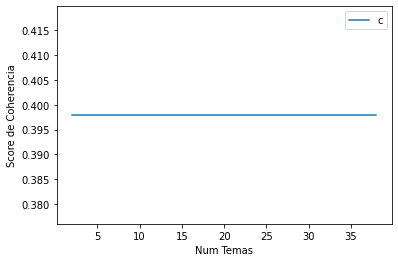

In [73]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Temas")
plt.ylabel("Score de Coherencia")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [74]:
# Imprimer la coherencia para cada modelo con N temas
for m, cv in zip(x, coherence_values):
    print("Num Temas :", m, " Coherencia: ", round(cv, 4))

Num Temas : 2  Coherencia:  0.3979
Num Temas : 8  Coherencia:  0.3979
Num Temas : 14  Coherencia:  0.3979
Num Temas : 20  Coherencia:  0.3979
Num Temas : 26  Coherencia:  0.3979
Num Temas : 32  Coherencia:  0.3979
Num Temas : 38  Coherencia:  0.3979


In [86]:
#Busqueda de Hiperparametros
# Define Search Param
search_params = {'n_components': [5, 15, 20], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid= search_params)

# Do the Grid Search
model.fit(prueba)

ValueError: ignored

In [80]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(prueba))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  nan


NotFittedError: ignored

In [83]:
#Matriz Documentos- Topicos
 # CreateTopic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Temas" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Documentos" + str(i) for i in range(len(datos))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Estilo del grafico
def color_green(val):
 color = 'Blue' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics


NotFittedError: ignored

In [84]:

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = [' # Topic', '# Documents']
df_topic_distribution



NameError: ignored

In [ ]:
#Matriz Topico Palabras
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

In [88]:
# Key Words for Topic
#  Palabras Clave dominantes por Topico
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.num_topics:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Palabra '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Tema'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

AttributeError: ignored